Part 1 - Classic vs. Deep Learning semantic segmentation

# Q1 - displaying the original images

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

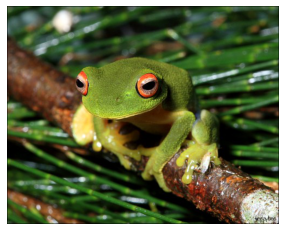

In [6]:
frog1 = cv2.imread('data/frogs/frog1.jpg')
plt.imshow(cv2.cvtColor(frog1, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

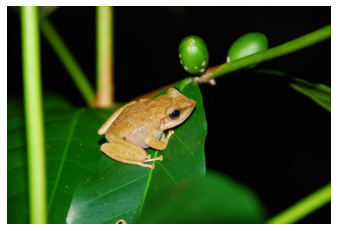

In [7]:
frog2 = cv2.imread('data/frogs/frog2.jpg')
plt.imshow(cv2.cvtColor(frog2, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

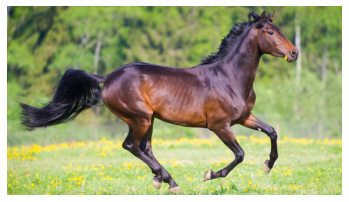

In [8]:
horse1 = cv2.imread('data/horses/horse1.png')
plt.imshow(cv2.cvtColor(horse1, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

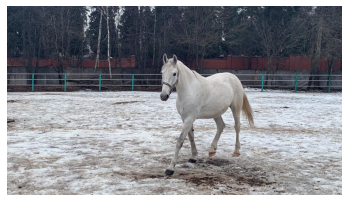

In [9]:
horse2 = cv2.imread('data/horses/horse2.jpg')
plt.imshow(cv2.cvtColor(horse2, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

# Watershed
## Implementation:

In [10]:
def getSegmentation(im, threshold=0.3, laplacian_ksize=5, blur_ksize=7, blur_var=1, closing_ksize=9):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=laplacian_ksize)

    laplacian = cv2.GaussianBlur(laplacian, (blur_ksize, blur_ksize), blur_var)

    laplacian = (laplacian / laplacian.max())
    # laplacian = np.int8(laplacian)

    _, laplacian = cv2.threshold(laplacian, threshold, 1, type=cv2.THRESH_BINARY)

    closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel=np.ones([closing_ksize, closing_ksize]))
    closing = np.int8(closing*255)

    _, markers = cv2.connectedComponents(closing)
    markers = np.int32(markers)

    markers = cv2.watershed(im, markers)

    return markers

In [11]:
def plot_marked_image(im):
    markers = getSegmentation(im,
                              threshold=0.2,
                              laplacian_ksize=9,
                              blur_ksize=9,
                              blur_var=1,
                              closing_ksize=5)
    _ = plt.figure(figsize=(100, 75))
    plt.imshow(markers)

## results:

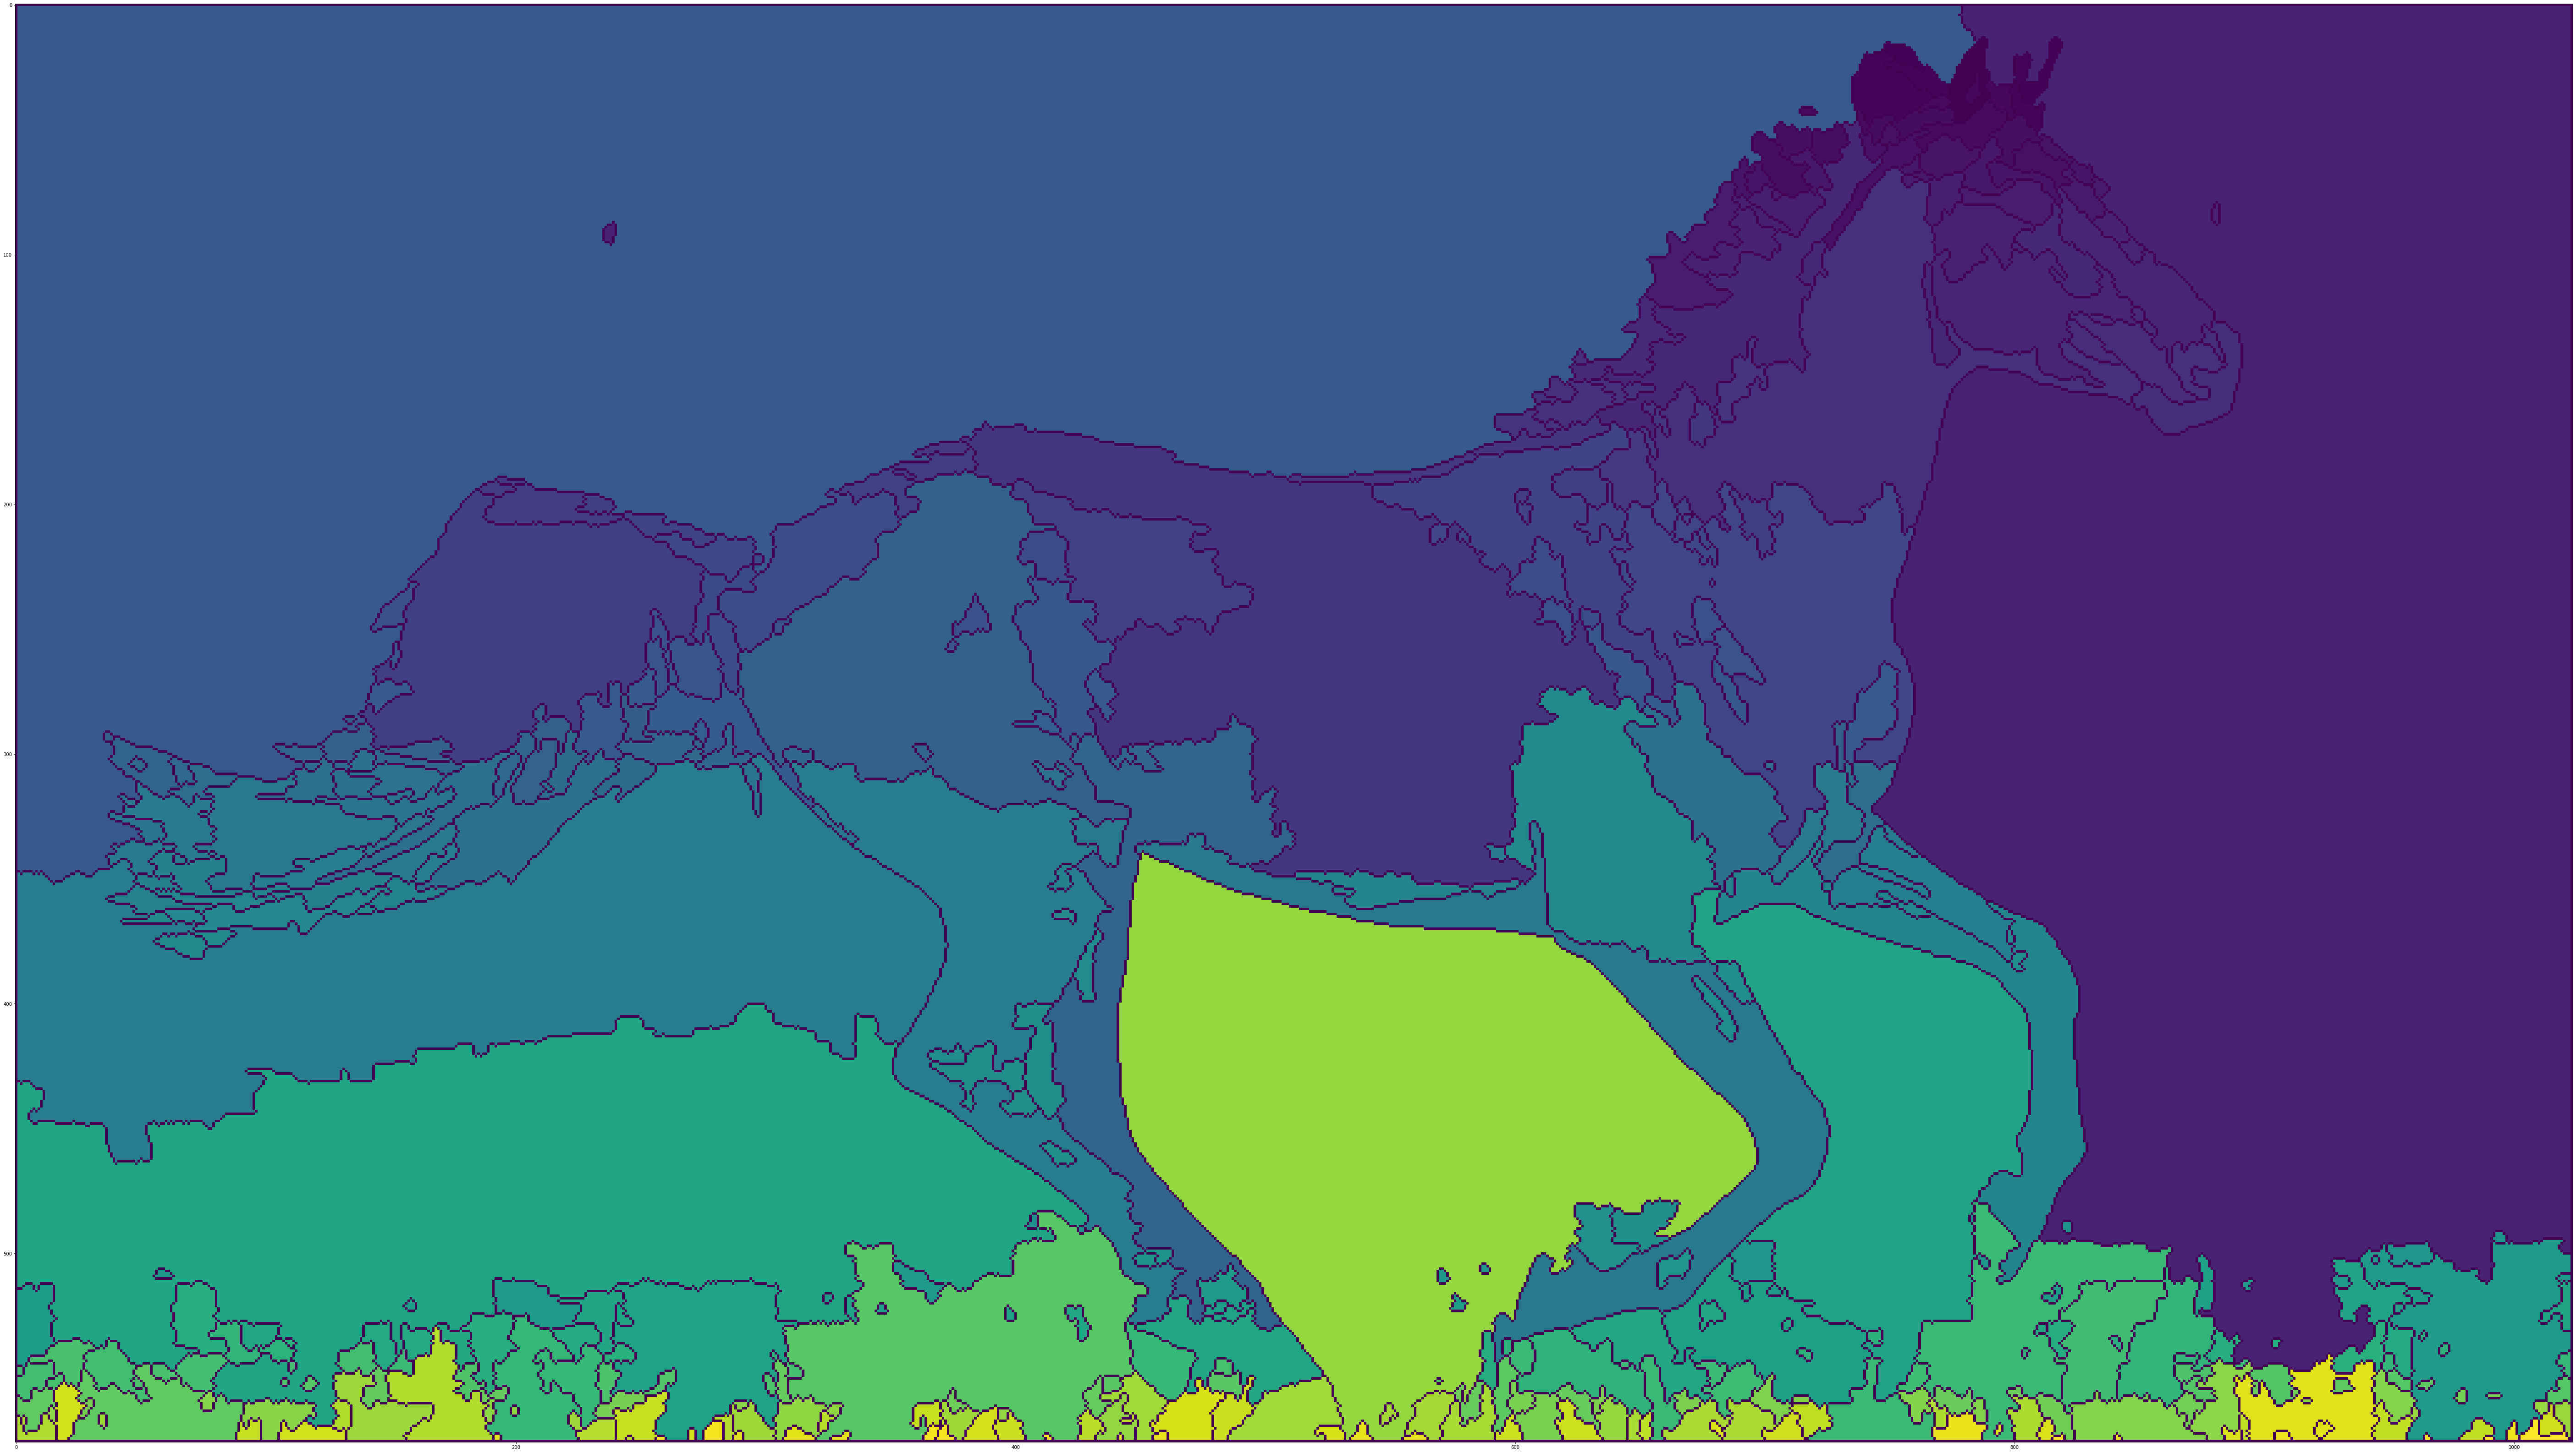

In [12]:
plot_marked_image(horse1)

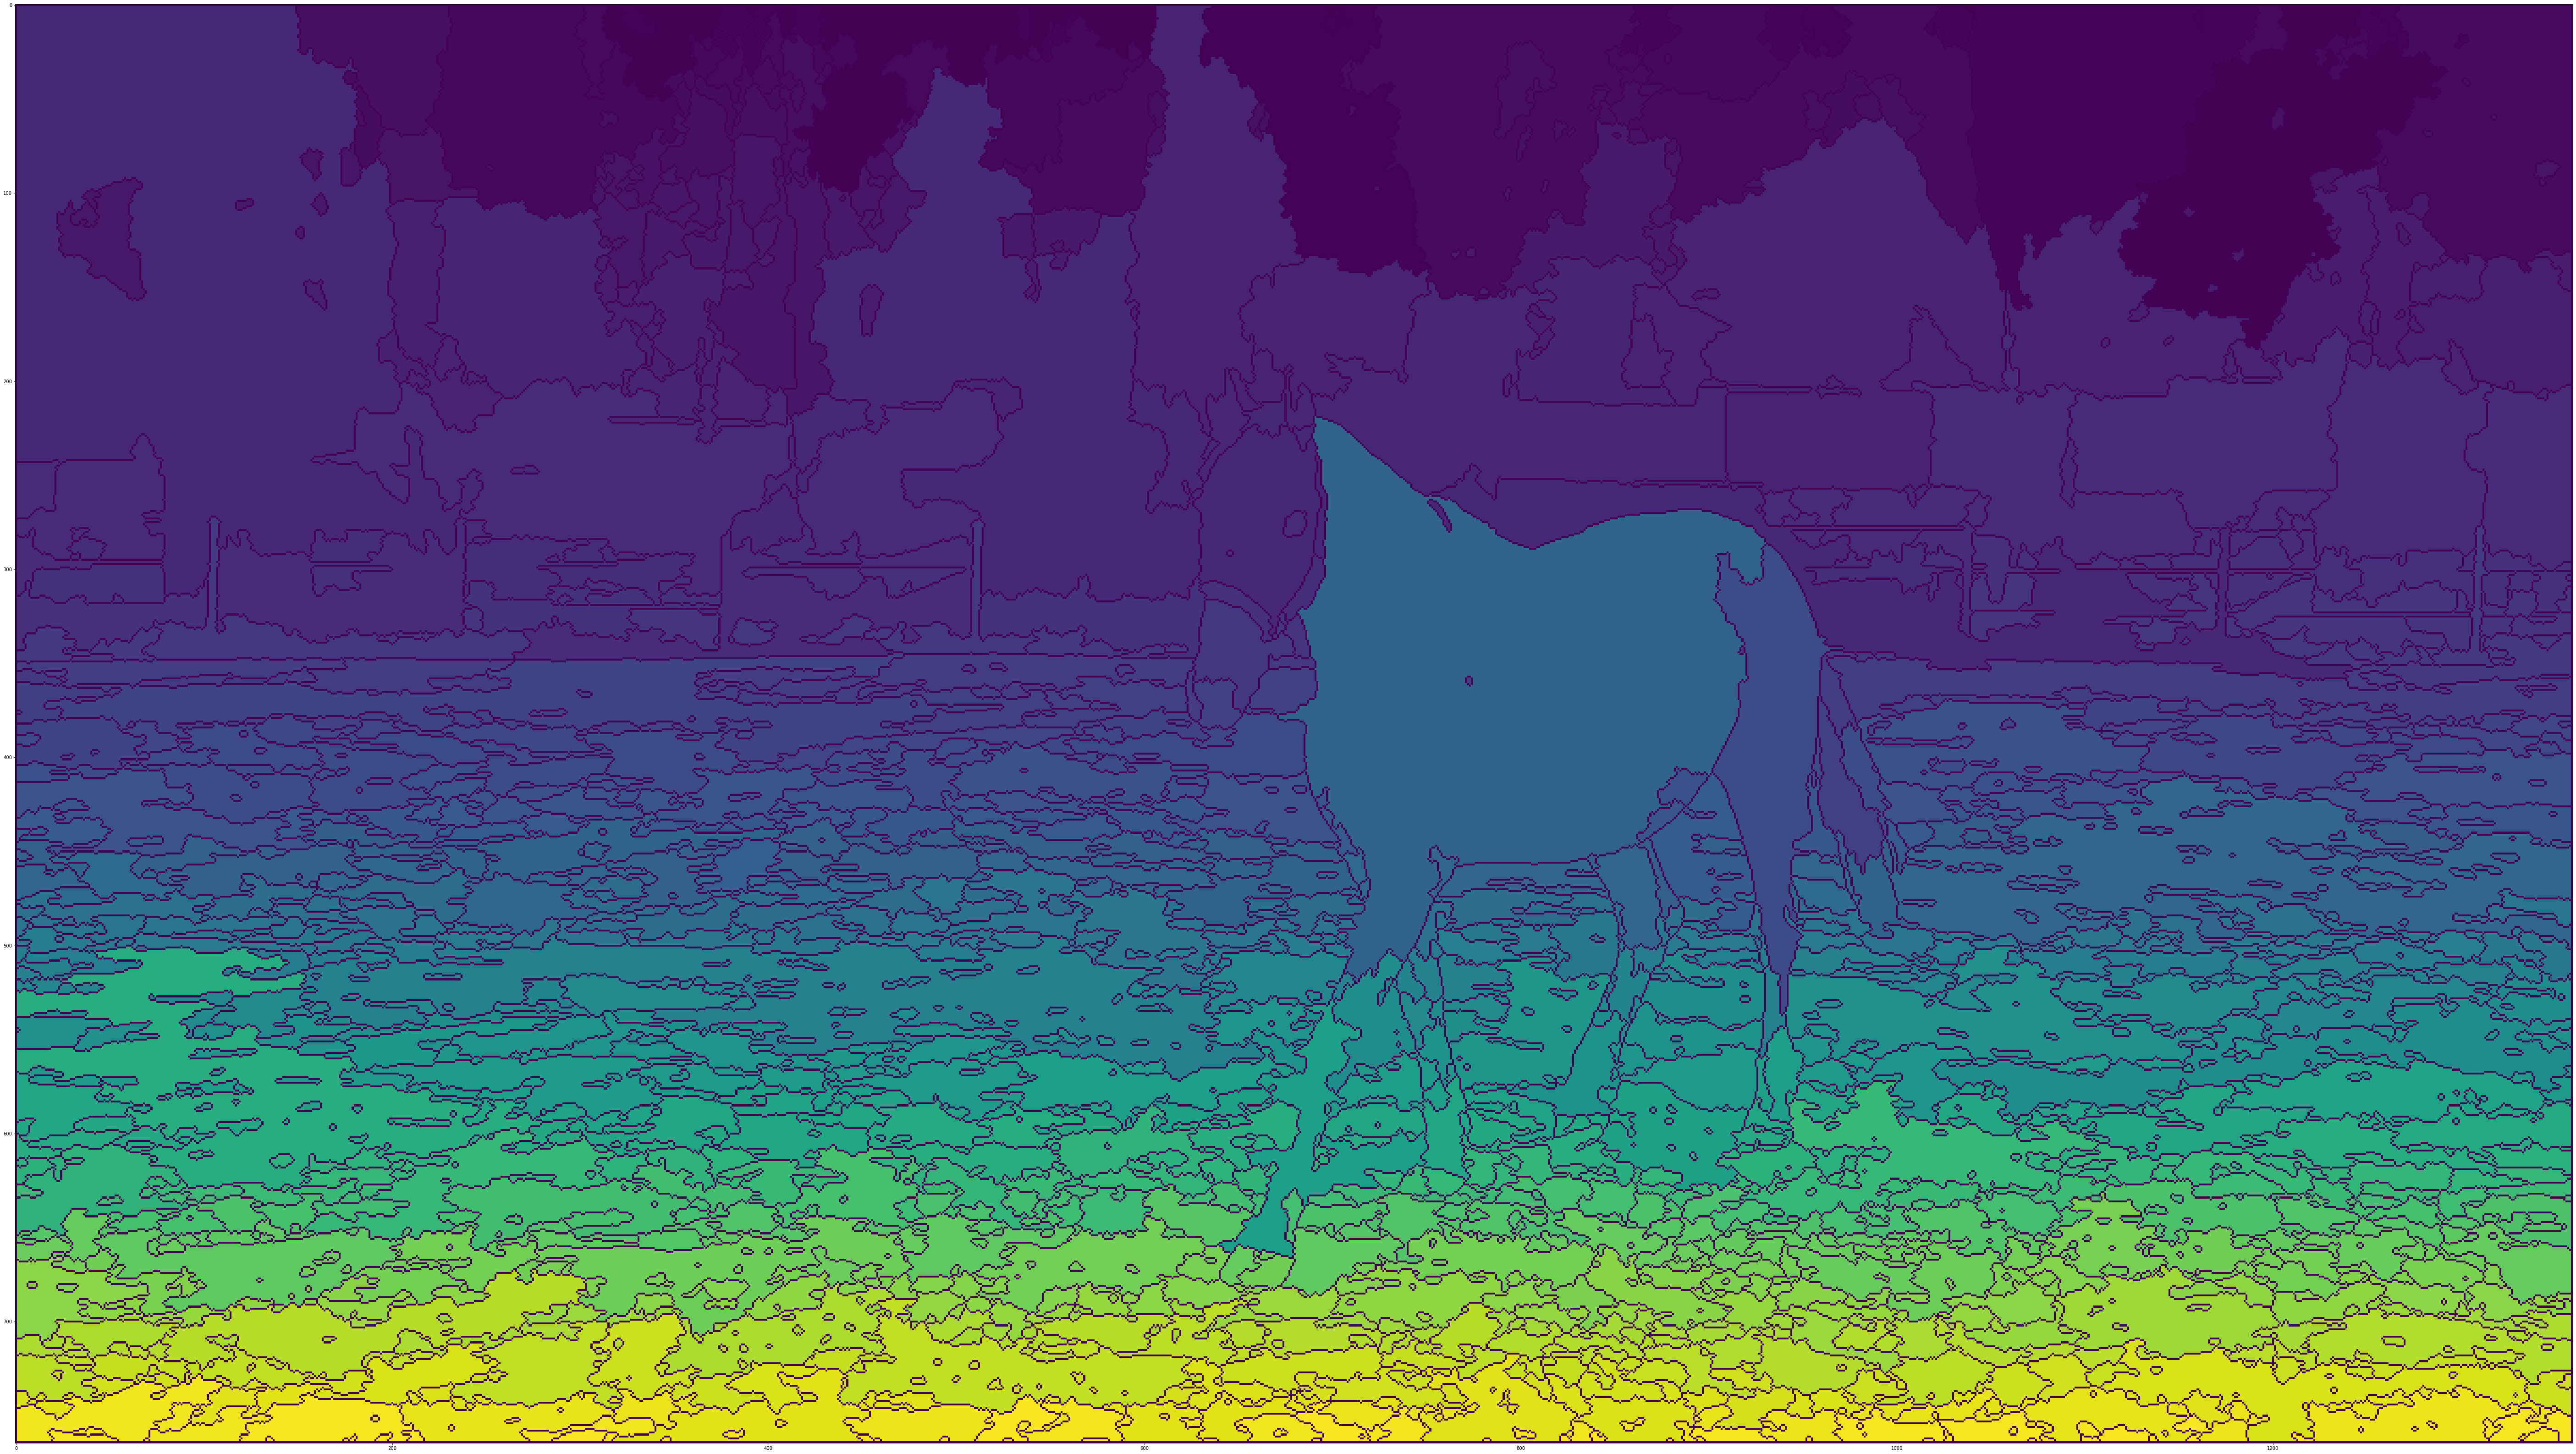

In [13]:
plot_marked_image(horse2)

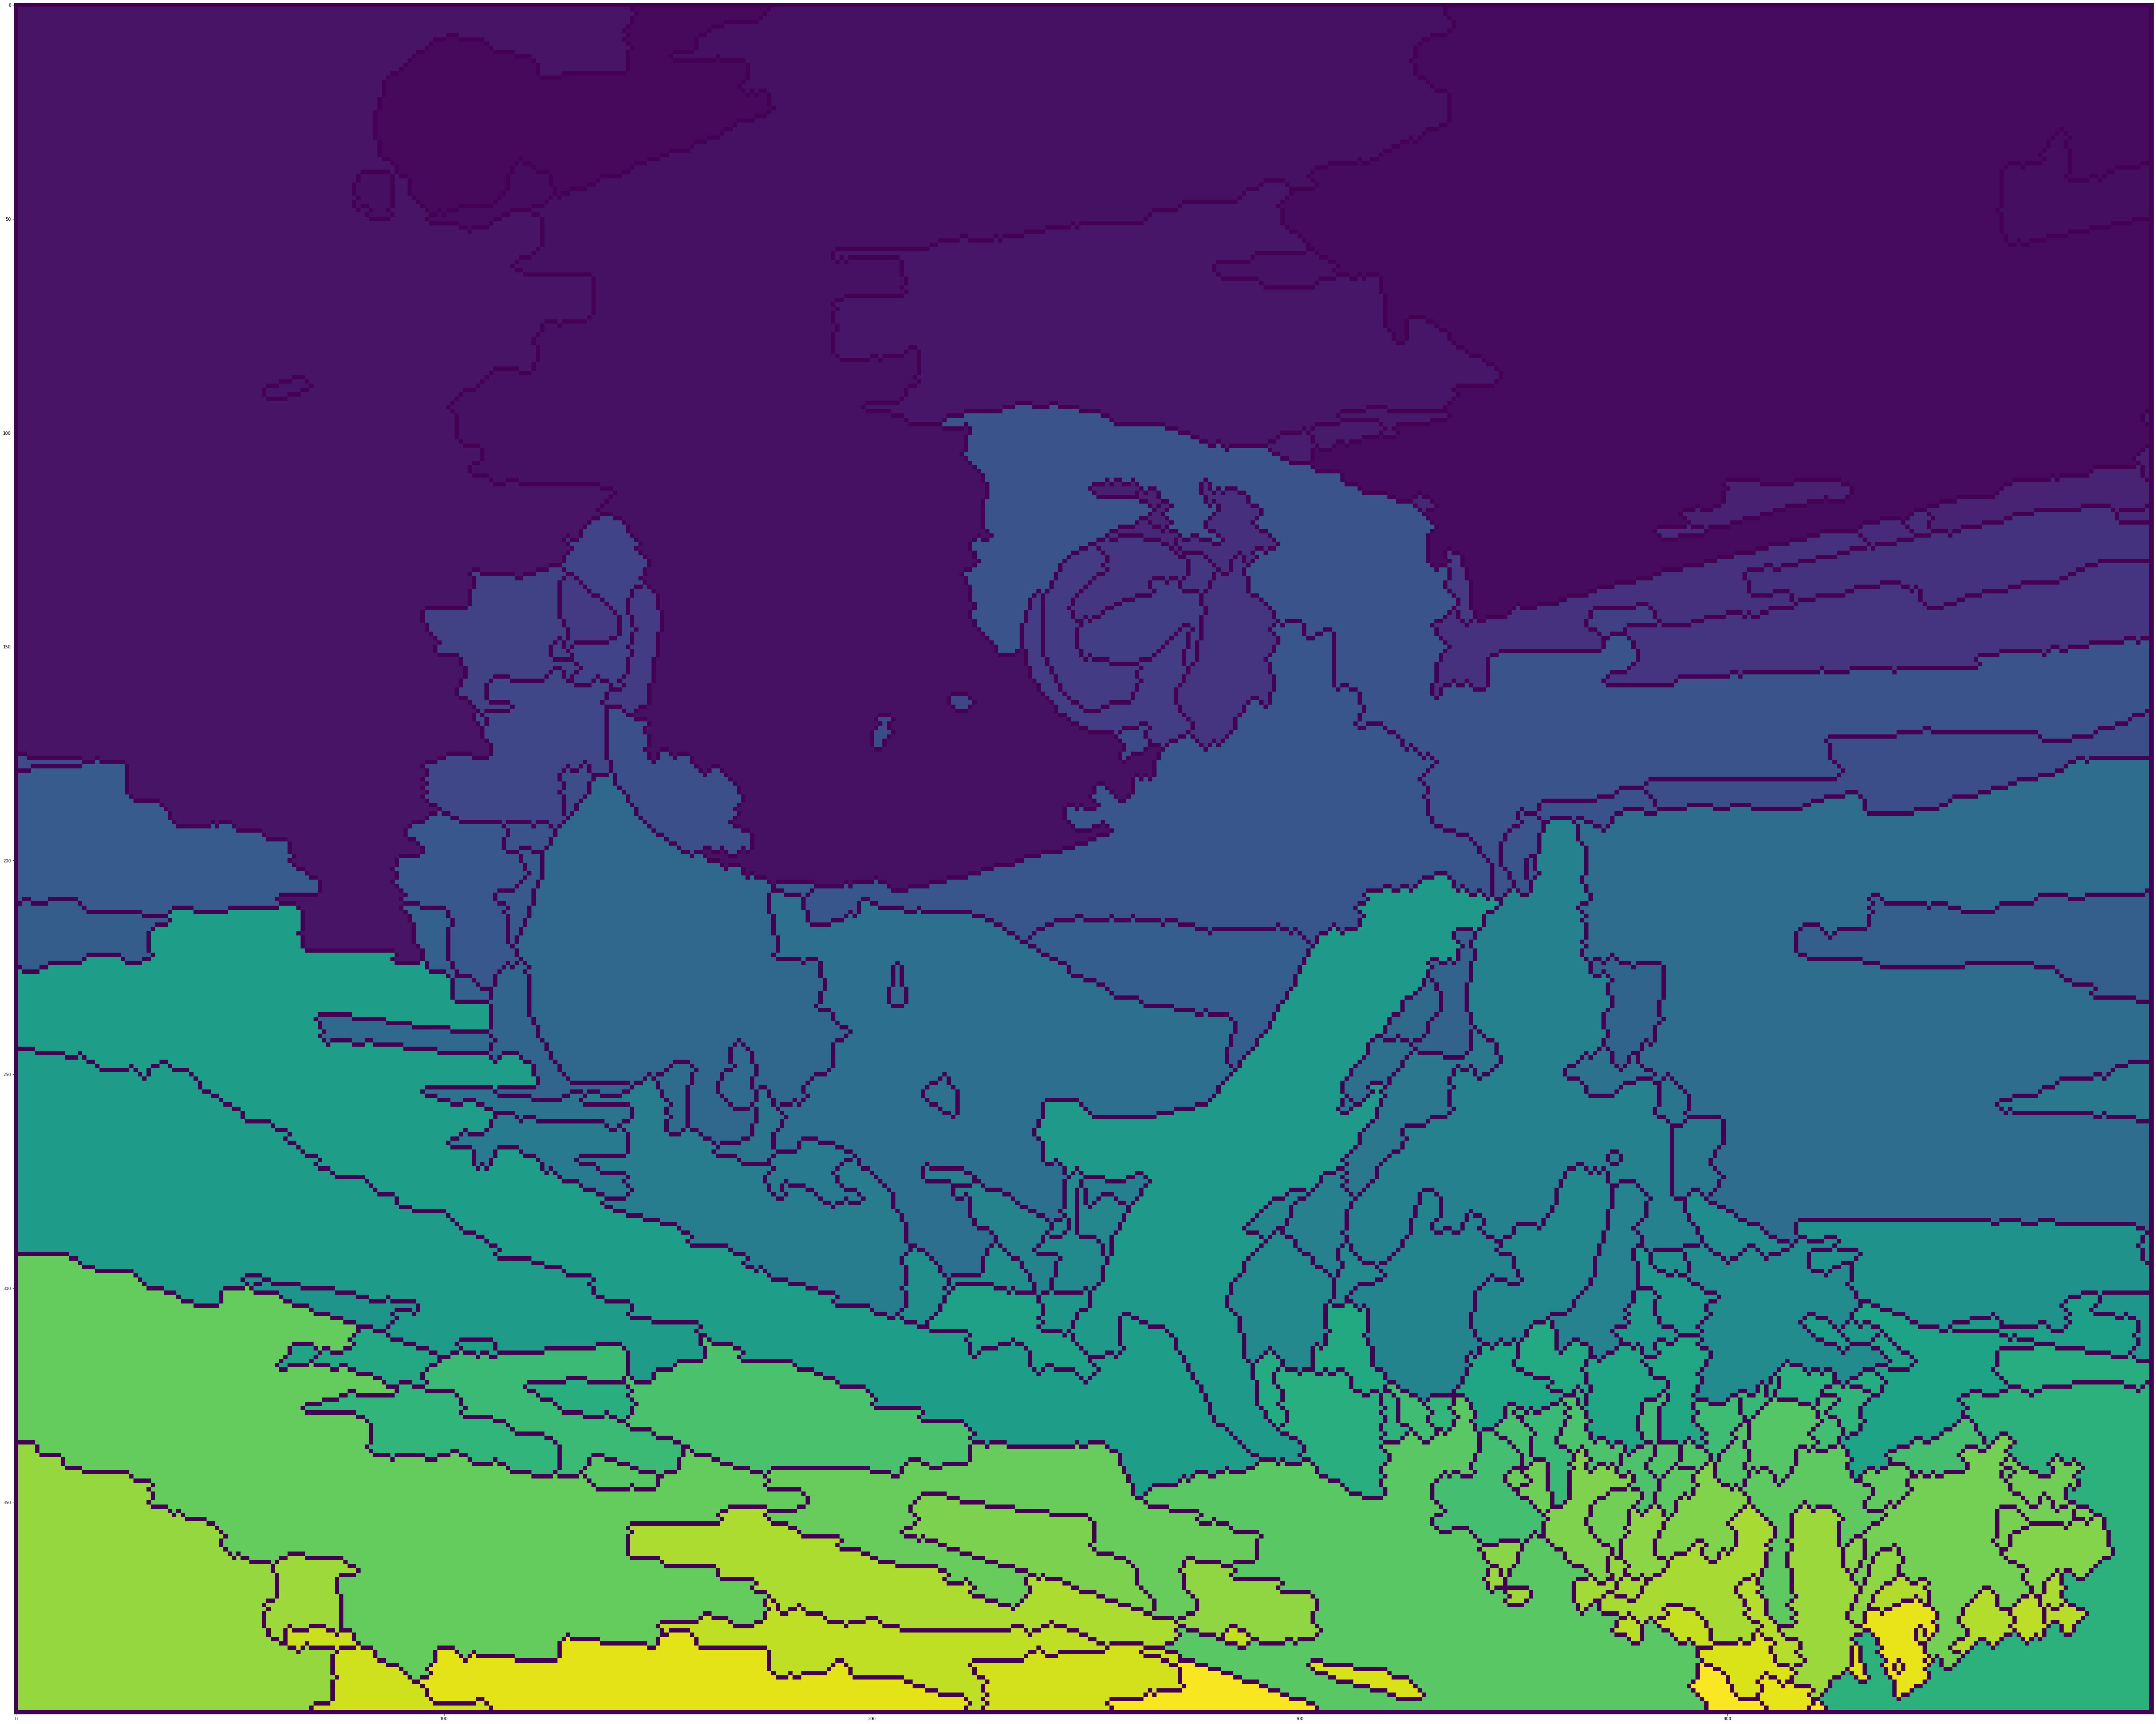

In [14]:
plot_marked_image(frog1)

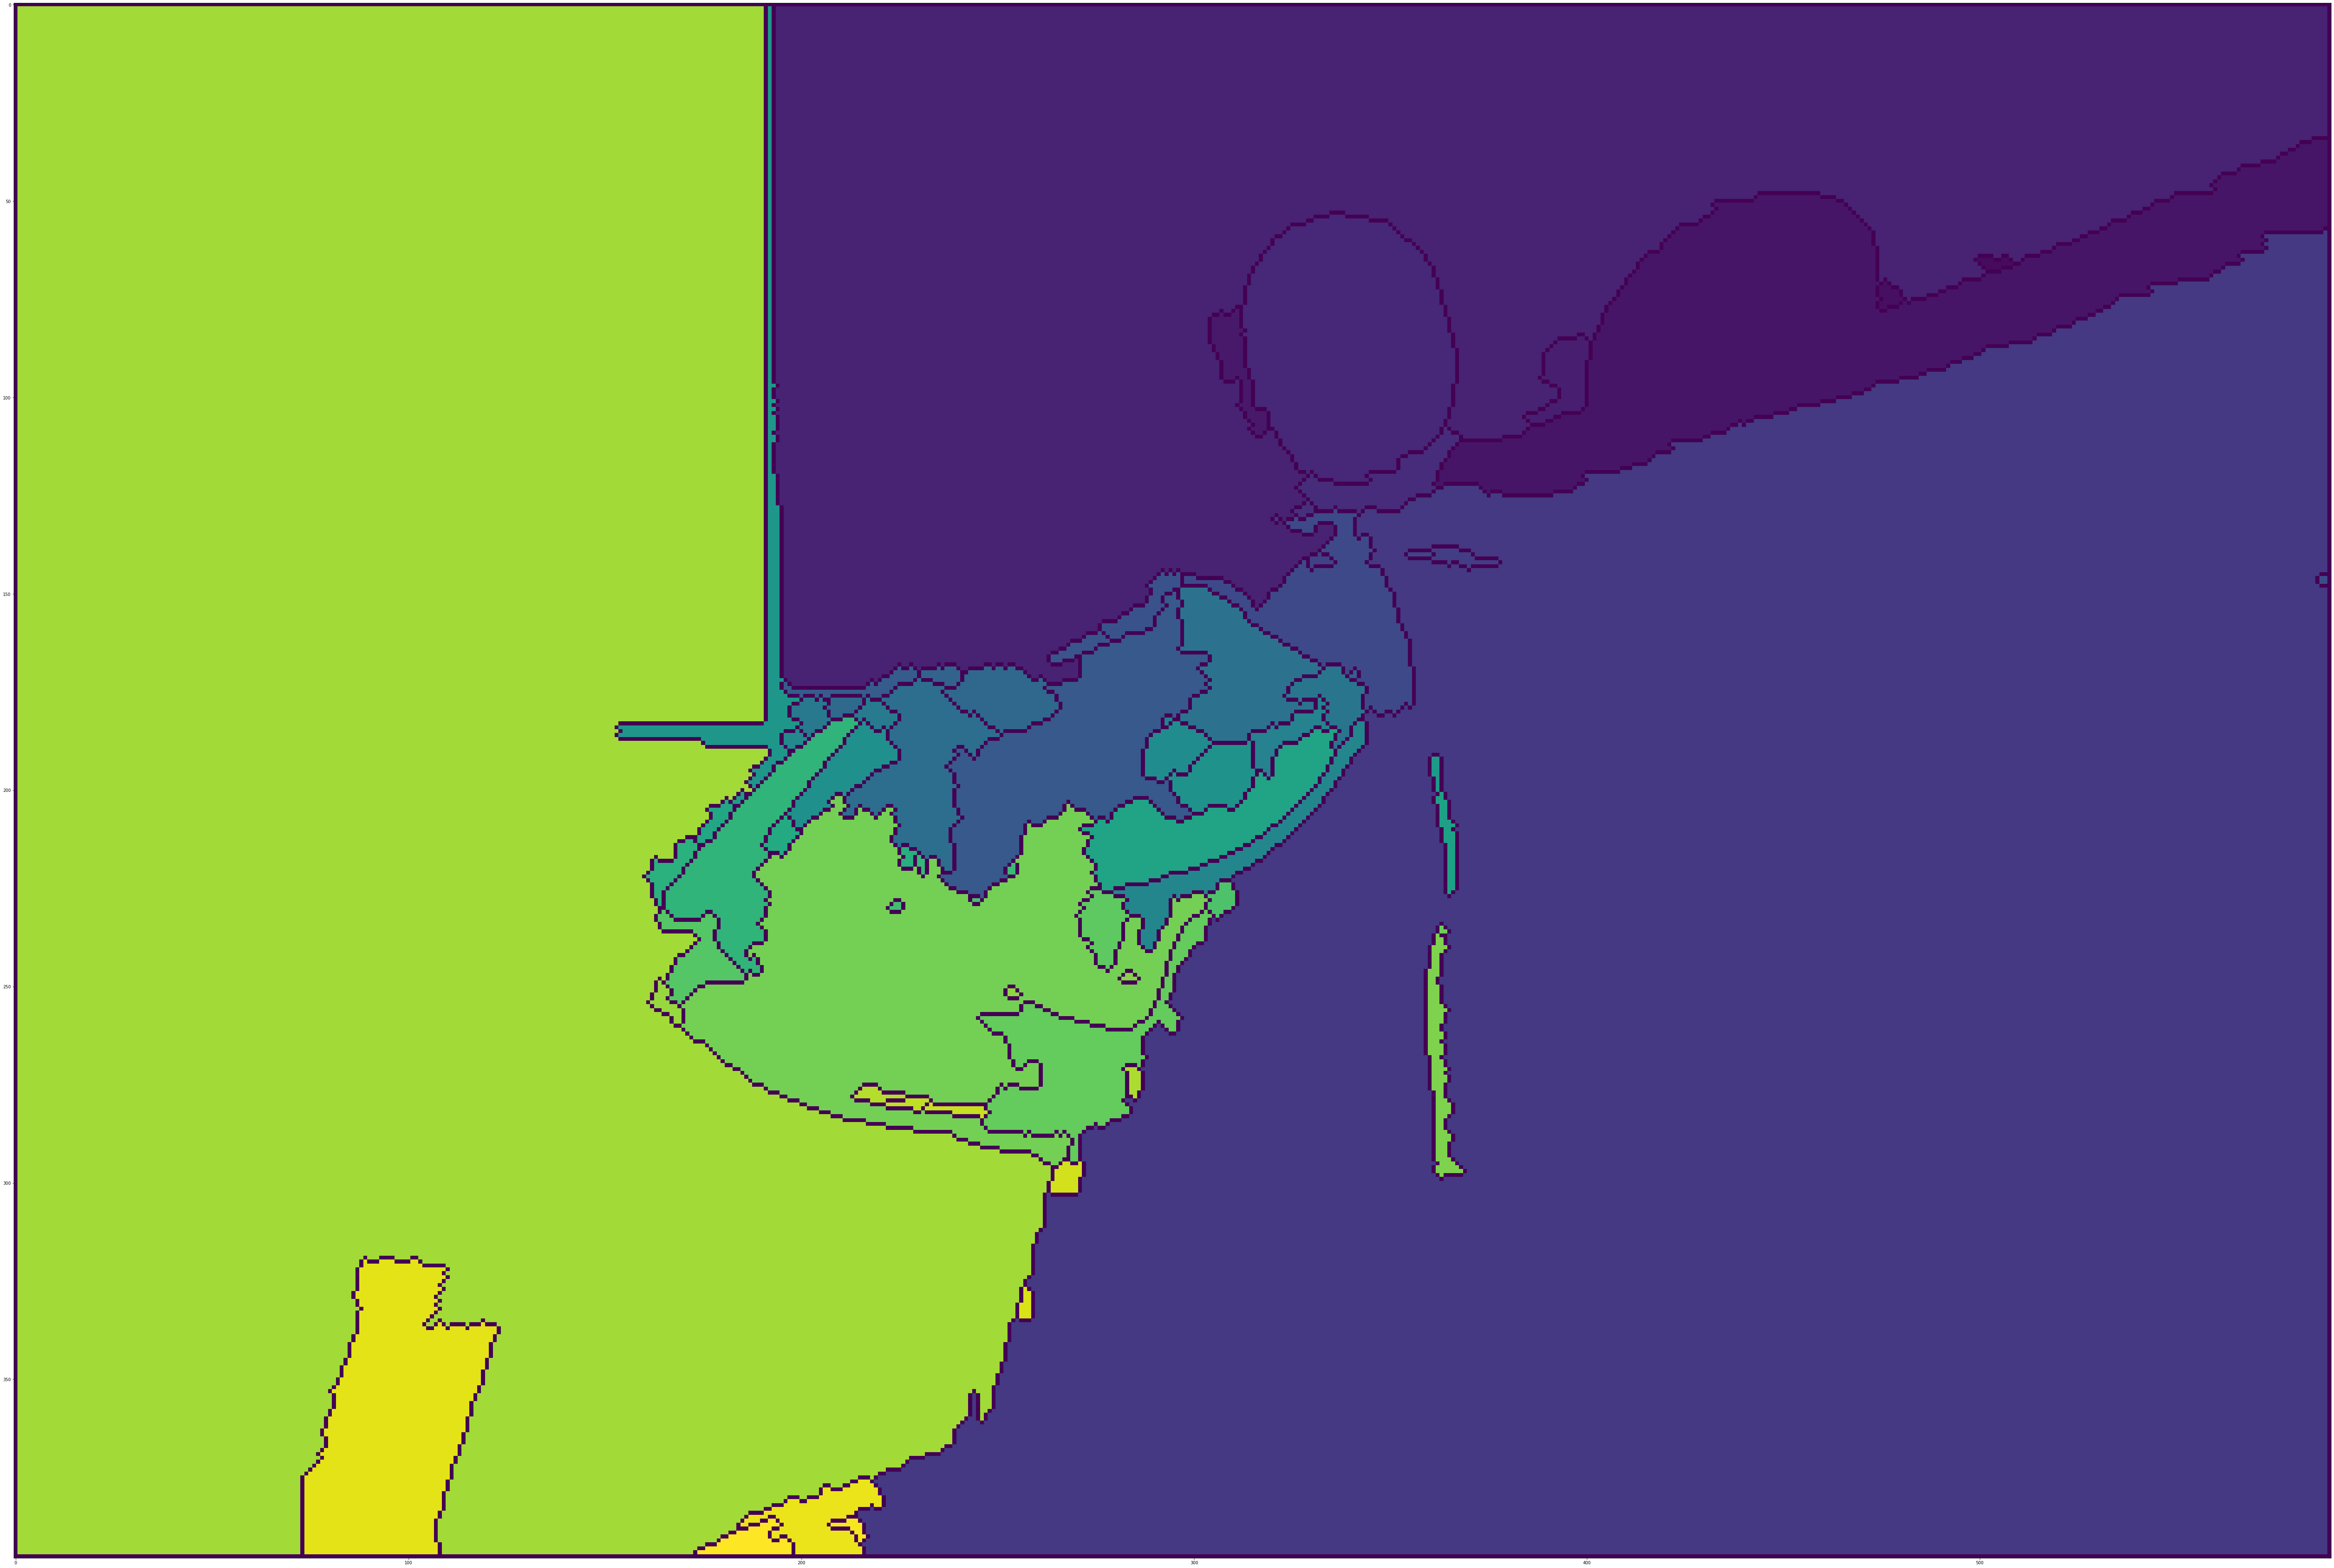

In [15]:
plot_marked_image(frog2)

# Deep Learning Algorithm -

In [28]:
import torch
import torchvision
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image

In [38]:
model = fcn_resnet50(pretrained=True)
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [74]:
def segment_image(image_path, device):
    image = Image.open(image_path)

    im_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(im_tensor)['out'][0]

    output_predictions = output.argmax(0)

    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(image.size)
    r.putpalette(colors)

    # plot
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.imshow(r)
    ax.set_axis_off()

    labels = ['background', 'aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

    # what labels were recognized?
    for label in np.unique(output_predictions.cpu().numpy()):
        print(labels[label])

background
dog
horse


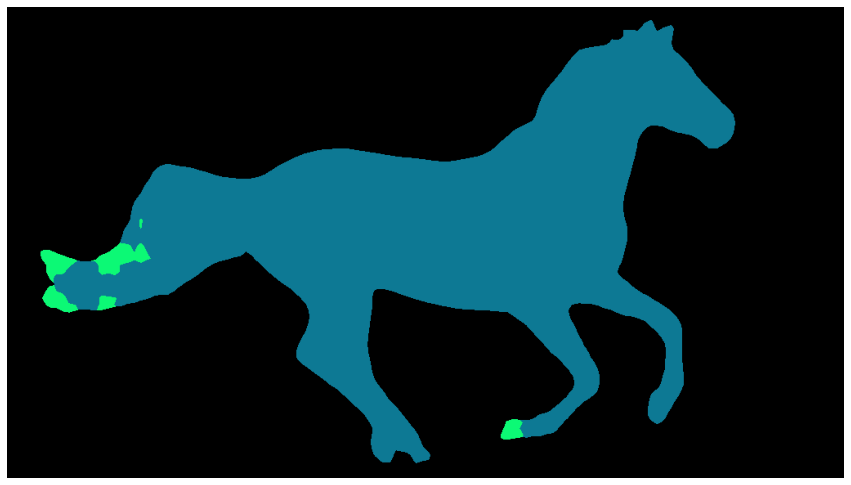

In [76]:
segment_image('data/horses/horse1.png', device)

background
horse


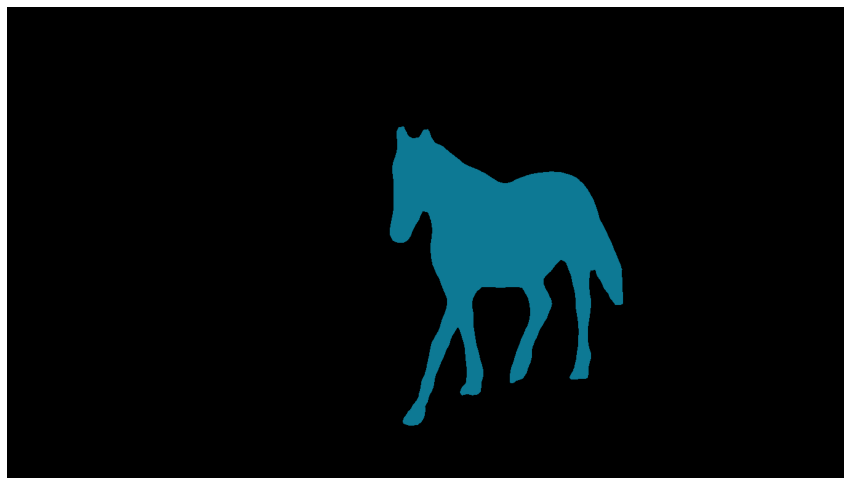

In [77]:
segment_image('data/horses/horse2.jpg', device)


background
bird


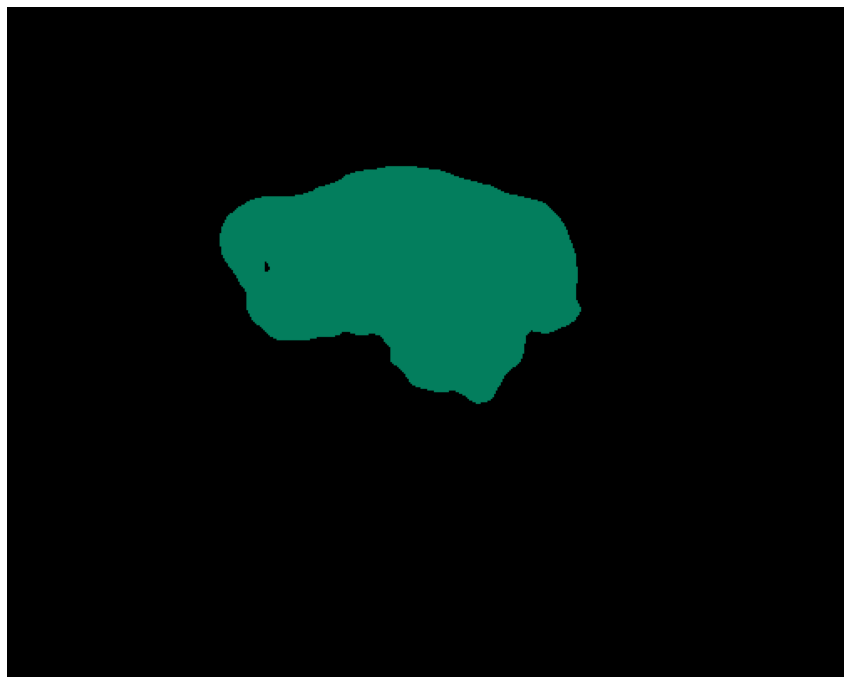

In [78]:
segment_image('data/frogs/frog1.jpg', device)

background
bird
person
pottedplant


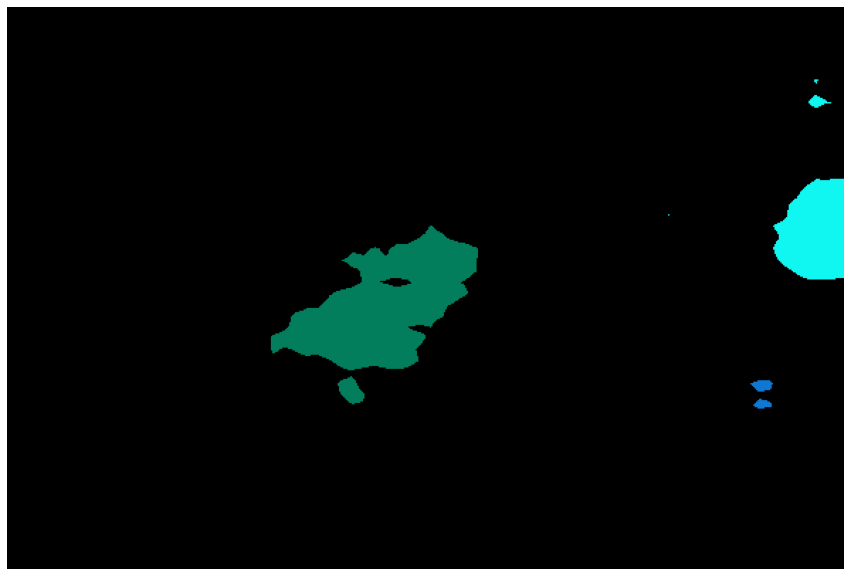

In [79]:
segment_image('data/frogs/frog2.jpg', device)